In [71]:
%load_ext autoreload
%autoreload 2

In [72]:
%reload_ext autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import class_weight
import graphviz
import pydot
import sys

In [2]:
import warnings
warnings.filterwarnings('always')

In [5]:
sys.path.insert(0, '..')
from data_wrangling import create_new_folder
from cnn_model import *
from resnet50 import *
from modeling_results import *

In [6]:
train = r'../train_images'
val = r'../val_images'
test = r'../test_images'

## INITIALIZE GENERATORS FOR TRAIN, VALIDATION, AND TEST SETS

In [7]:
image_size = (200, 200) #(height, width)
batch_size = 32
num_classes = len(os.listdir(train))

train_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.1,
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest'
                              )

val_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(directory=train, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = batch_size,
                                              seed=42)

validation_generator = val_gen.flow_from_directory(directory=val, 
                                                   target_size=image_size,
                                                   color_mode='rgb',
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   seed=42)

test_generator = test_gen.flow_from_directory(directory=test, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = 1,
                                              shuffle = False,
                                                   seed=42)

Found 1662 images belonging to 6 classes.
Found 206 images belonging to 6 classes.
Found 230 images belonging to 6 classes.


#### PREVIEW TRAIN DATASET

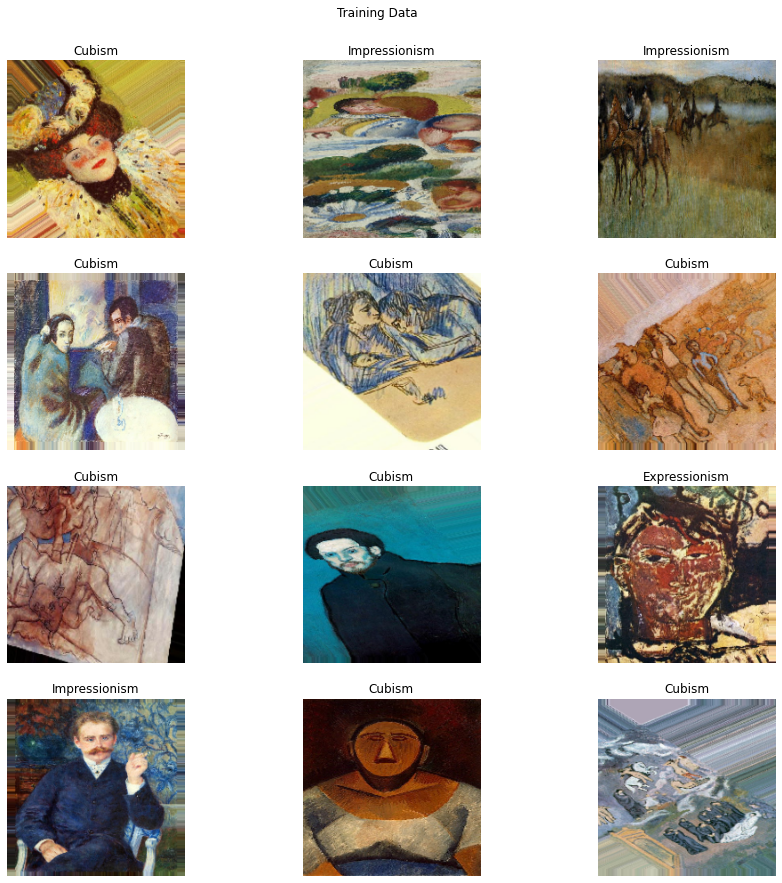

In [13]:
plt.figure(figsize=(15,15))

x, y = train_generator.__getitem__(10) #returns batch of size 32; arg is a random sequence of the batch
x = x.reshape((1,)+x.shape)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y = [np.argmax(i) for i in y]
y = [labels[k] for k in y]

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis("off")
plt.suptitle('Training Data', y=0.93)
plt.show()

In [8]:
modelpath = r'../models'
epochs = 25

# CNN MODEL

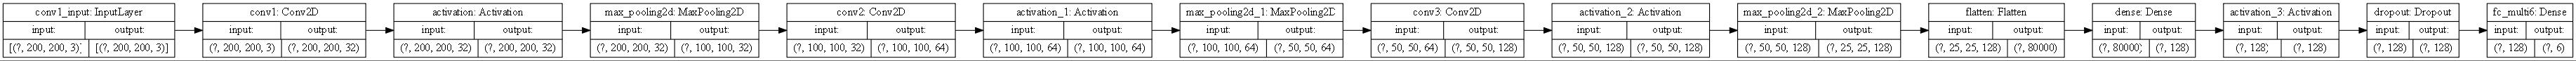

In [9]:
model = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, to_file='../graphs/cnn_model.jpg', show_shapes=True, dpi=80, rankdir='LR')

In [10]:
model.load_weights('../models/model_cnn_checkpoint_25.h5')

In [11]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnn_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

cnn_history = model.fit(train_generator,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=validation_generator,)

Epoch 1/25
52/52 [==============================] - 101s 2s/step - loss: 0.4903 - accuracy: 0.8369 - val_loss: 0.6507 - val_accuracy: 0.8155
Epoch 2/25
52/52 [==============================] - 95s 2s/step - loss: 0.3515 - accuracy: 0.8887 - val_loss: 0.6013 - val_accuracy: 0.8350
Epoch 3/25
52/52 [==============================] - 92s 2s/step - loss: 0.3114 - accuracy: 0.8935 - val_loss: 0.6125 - val_accuracy: 0.8252
Epoch 4/25
52/52 [==============================] - 89s 2s/step - loss: 0.2805 - accuracy: 0.9025 - val_loss: 0.6876 - val_accuracy: 0.8252
Epoch 5/25
52/52 [==============================] - 89s 2s/step - loss: 0.2789 - accuracy: 0.9019 - val_loss: 0.9111 - val_accuracy: 0.7718
Epoch 6/25
52/52 [==============================] - 88s 2s/step - loss: 0.2636 - accuracy: 0.9097 - val_loss: 0.9281 - val_accuracy: 0.7379
Epoch 7/25
52/52 [==============================] - 90s 2s/step - loss: 0.2699 - accuracy: 0.9110 - val_loss: 0.7000 - val_accuracy: 0.8252
Epoch 8/25
52/52 [=

In [19]:
print(model.summary())

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 200, 200, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 100, 100, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 50, 50, 128)       73

#### SAVE METRICS AND PREDICTION RESULTS

In [47]:
#Save train/val accuracy and train/val loss
cnn_hist = pd.DataFrame(cnn_history.history)
cnn_hist.to_csv(f'../results/cnn_hist_{epochs}epochs.csv', index=False)

In [12]:
model.evaluate(validation_generator)

7/7 [==============================] - 4s 524ms/step - loss: 0.8836 - accuracy: 0.8155


[0.8835880160331726, 0.8155339956283569]

In [65]:
def plot_confusion_matrix(cm, labels):
    """
    Displays confusion matrix plot
    :param cm: confusion matrix data
    :param labels: class labels
    :return: None
    """
    df_cm = pd.DataFrame(cm, index=[i for i in labels],
                         columns=[i for i in labels])

    plt.figure(figsize=(10, 5))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix')

    return None

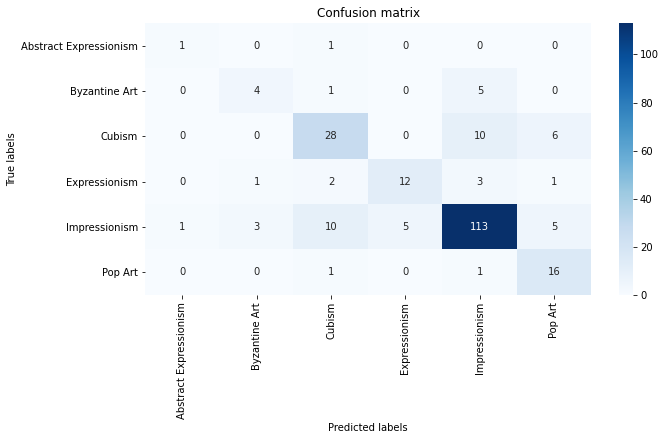

In [64]:
labels=os.listdir(train)
cm = confusion_matrix(list(results.True_Label), list(results.Predictions), labels=labels)
plot_confusion_matrix(cm, labels)

In [40]:
cnn_pred_df = pd.read_csv('../results/cnn_pred_results.csv')


Impressionism             137
Cubism                     44
Expressionism              19
Pop Art                    18
Byzantine Art              10
Abstract Expressionism      2
Name: True_Label, dtype: int64

In [17]:
test_generator.reset()
pred = model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'cnn_pred_results')
metric_eval(test_generator, pred, results, labels=os.listdir(train))    

230/230 [==============================] - 5s 23ms/step


# WEIGHTED CNN MODEL

In [74]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_generator.labels), y=train_generator.labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [60]:
wmodel = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)

In [61]:
wmodel.load_weights('../models/model_cnnweighted_checkpoint_25.h5')

In [76]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnnweighted_checkpoint_{epochs}.h5')),]

wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

weight_cnn_history = wmodel.fit(train_generator, 
                                epochs=epochs, 
                                callbacks=callbacks, 
                                validation_data=validation_generator, 
                                class_weight=class_weights)

Epoch 1/25
43/43 [==============================] - 69s 2s/step - loss: 1.9358 - accuracy: 0.1887 - val_loss: 1.7800 - val_accuracy: 0.1117
Epoch 2/25
43/43 [==============================] - 71s 2s/step - loss: 1.6987 - accuracy: 0.1976 - val_loss: 1.6978 - val_accuracy: 0.2184
Epoch 3/25
43/43 [==============================] - 68s 2s/step - loss: 1.6179 - accuracy: 0.2487 - val_loss: 1.6139 - val_accuracy: 0.2961
Epoch 4/25
43/43 [==============================] - 66s 2s/step - loss: 1.5753 - accuracy: 0.2724 - val_loss: 1.4946 - val_accuracy: 0.4126
Epoch 5/25
43/43 [==============================] - 65s 2s/step - loss: 1.4146 - accuracy: 0.3790 - val_loss: 1.7993 - val_accuracy: 0.2379
Epoch 6/25
43/43 [==============================] - 65s 2s/step - loss: 1.4803 - accuracy: 0.3597 - val_loss: 1.5537 - val_accuracy: 0.3010
Epoch 7/25
43/43 [==============================] - 65s 2s/step - loss: 1.2695 - accuracy: 0.4071 - val_loss: 1.7958 - val_accuracy: 0.3495
Epoch 8/25
43/43 [==

In [78]:
#Save train/val accuracy and train/val loss
weight_cnn_hist = pd.DataFrame(weight_cnn_history.history)
weight_cnn_hist.to_csv(f'../results/weight_cnn_hist_{epochs}epochs.csv', index=False)

In [79]:
wmodel.evaluate(validation_generator)

7/7 [==============================] - 4s 511ms/step - loss: 1.0130 - accuracy: 0.7039


[1.0130125284194946, 0.7038834691047668]

#### SAVE METRICS AND PREDICTION RESULTS

230/230 [==============================] - 6s 25ms/step


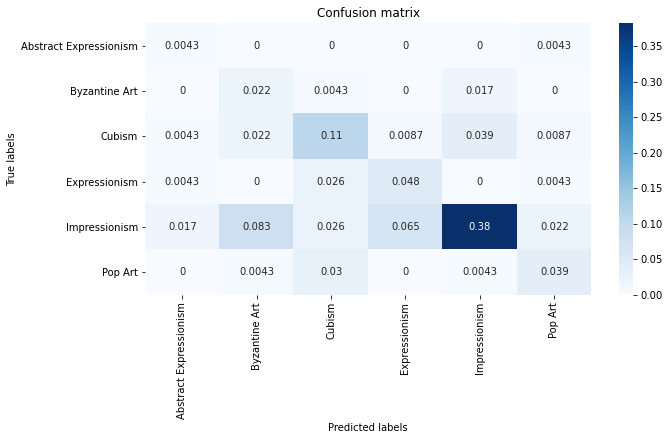

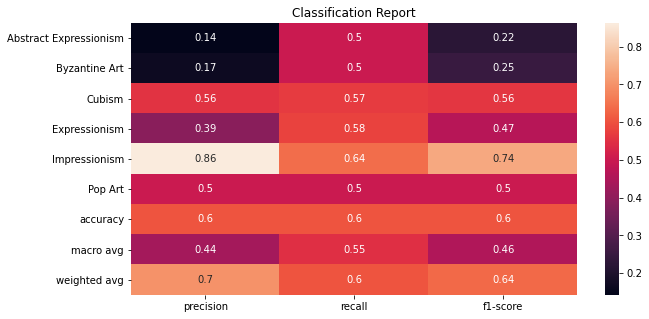

precision    recall  f1-score     support
Abstract Expressionism   0.142857  0.500000  0.222222    2.000000
Byzantine Art            0.166667  0.500000  0.250000   10.000000
Cubism                   0.555556  0.568182  0.561798   44.000000
Expressionism            0.392857  0.578947  0.468085   19.000000
Impressionism            0.862745  0.642336  0.736402  137.000000
Pop Art                  0.500000  0.500000  0.500000   18.000000
accuracy                 0.604348  0.604348  0.604348    0.604348
macro avg                0.436780  0.548244  0.456418  230.000000
weighted avg             0.700249  0.604348  0.636714  230.000000

In [62]:
test_generator.reset()
pred = wmodel.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'cnn_model_pred_weighted_results')
metric_eval(test_generator, pred, results, labels=os.listdir(train))  

# RESNET50 MODEL

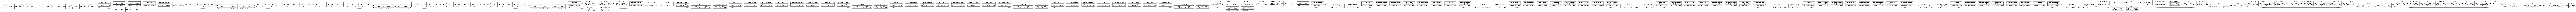

In [27]:
resnet50model = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)
keras.utils.plot_model(resnet50model, to_file='../graphs/resnet50_model.jpg', show_shapes=True, dpi=80, rankdir='LR')

In [64]:
resnet50model.load_weights('../models/model_resnet50weighted_checkpoint_25.h5')

In [84]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5')),]

resnet50model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

r50_history = resnet50model.fit(train_generator,
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  validation_data=validation_generator,
                                  batch_size=batch_size)

Epoch 1/25
43/43 [==============================] - 206s 5s/step - loss: 3.5932 - accuracy: 0.4730 - val_loss: 1.4042 - val_accuracy: 0.5971
Epoch 2/25
43/43 [==============================] - 203s 5s/step - loss: 2.4593 - accuracy: 0.5396 - val_loss: 1.2302 - val_accuracy: 0.5971
Epoch 3/25
43/43 [==============================] - 209s 5s/step - loss: 2.2061 - accuracy: 0.5352 - val_loss: 1.3170 - val_accuracy: 0.5971
Epoch 4/25
43/43 [==============================] - 214s 5s/step - loss: 1.8025 - accuracy: 0.5759 - val_loss: 1.6091 - val_accuracy: 0.5971
Epoch 5/25
43/43 [==============================] - 201s 5s/step - loss: 1.4173 - accuracy: 0.6070 - val_loss: 1.3852 - val_accuracy: 0.5971
Epoch 6/25
43/43 [==============================] - 202s 5s/step - loss: 1.3251 - accuracy: 0.5825 - val_loss: 1.9934 - val_accuracy: 0.5971
Epoch 7/25
43/43 [==============================] - 205s 5s/step - loss: 1.3504 - accuracy: 0.6107 - val_loss: 1.4815 - val_accuracy: 0.5971
Epoch 8/25
43

In [85]:
print(resnet50model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [86]:
#Save train/val accuracy and train/val loss
r50_hist = pd.DataFrame(r50_history.history)
r50_hist.to_csv(f'../results/r50_hist_{epochs}epochs.csv', index=False)

In [87]:
resnet50model.evaluate(validation_generator)

7/7 [==============================] - 4s 625ms/step - loss: 5.9593 - accuracy: 0.5388


[5.959331035614014, 0.5388349294662476]

#### SAVE METRICS AND PREDICTION RESULTS

230/230 [==============================] - 9s 39ms/step


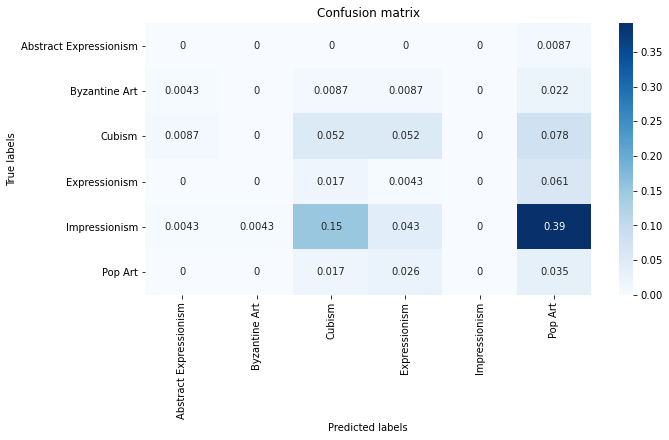

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

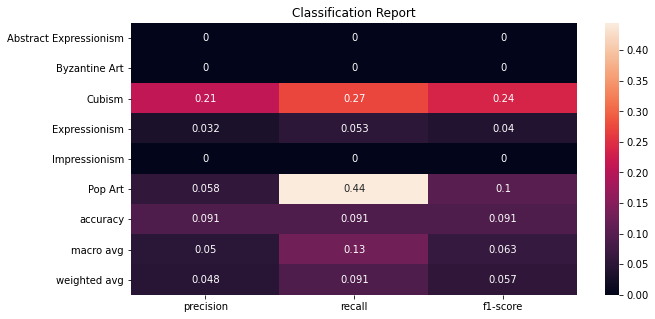

precision    recall  f1-score     support
Abstract Expressionism   0.000000  0.000000  0.000000    2.000000
Byzantine Art            0.000000  0.000000  0.000000   10.000000
Cubism                   0.210526  0.272727  0.237624   44.000000
Expressionism            0.032258  0.052632  0.040000   19.000000
Impressionism            0.000000  0.000000  0.000000  137.000000
Pop Art                  0.058394  0.444444  0.103226   18.000000
accuracy                 0.091304  0.091304  0.091304    0.091304
macro avg                0.050196  0.128301  0.063475  230.000000
weighted avg             0.047509  0.091304  0.056841  230.000000

In [65]:
test_generator.reset()
rn50pred = resnet50model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, rn50pred, 'resnet50_model_results')
metric_eval(test_generator, rn50pred, results, labels=os.listdir(train))

# RESNET50 WEIGHTED MODEL

In [66]:
r50wmodel = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)

In [67]:
r50wmodel.load_weights('../models/model_resnet50_checkpoint_25.h5')

In [93]:
#this uses class weights
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50weighted_checkpoint_{epochs}.h5')),]

r50wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

r50weight_history = r50wmodel.fit(train_generator,
                  epochs=epochs,
                  callbacks=callbacks,
                  validation_data=validation_generator,
                  class_weight=class_weights)

Epoch 1/25
43/43 [==============================] - 203s 5s/step - loss: 8.6885 - accuracy: 0.2443 - val_loss: 1.5741 - val_accuracy: 0.5971
Epoch 2/25
43/43 [==============================] - 202s 5s/step - loss: 2.8075 - accuracy: 0.2524 - val_loss: 24.3090 - val_accuracy: 0.3398
Epoch 3/25
43/43 [==============================] - 202s 5s/step - loss: 2.7931 - accuracy: 0.2709 - val_loss: 4684.5034 - val_accuracy: 0.0097
Epoch 4/25
43/43 [==============================] - 202s 5s/step - loss: 2.5425 - accuracy: 0.2435 - val_loss: 1767.9150 - val_accuracy: 0.0388
Epoch 5/25
43/43 [==============================] - 212s 5s/step - loss: 1.8276 - accuracy: 0.3087 - val_loss: 2.3390 - val_accuracy: 0.5971
Epoch 6/25
43/43 [==============================] - 214s 5s/step - loss: 1.7163 - accuracy: 0.3649 - val_loss: 12.4065 - val_accuracy: 0.1068
Epoch 7/25
43/43 [==============================] - 211s 5s/step - loss: 2.0480 - accuracy: 0.2798 - val_loss: 311.4183 - val_accuracy: 0.3544
Epo

In [95]:
#Save train/val accuracy and train/val loss
r50w_hist = pd.DataFrame(r50weight_history.history)
r50w_hist.to_csv(f'../results/r50_weight_hist_{epochs}epochs.csv', index=False)

In [96]:
r50wmodel.evaluate(validation_generator, verbose=1) 

7/7 [==============================] - 5s 668ms/step - loss: 6.5135 - accuracy: 0.1262


[6.513483047485352, 0.12621359527111053]

#### SAVE METRICS AND PREDICTION RESULTS

230/230 [==============================] - 9s 40ms/step


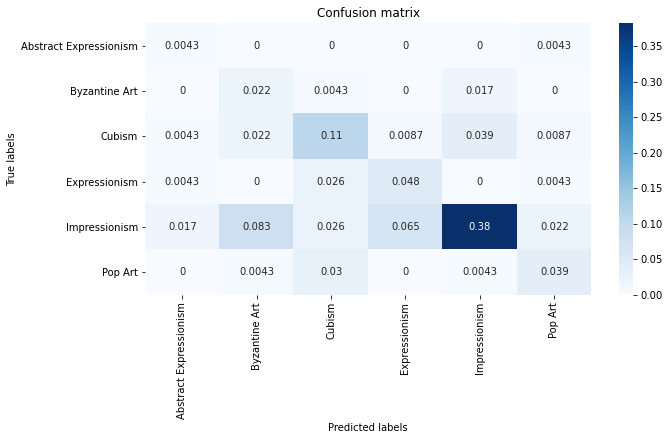

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

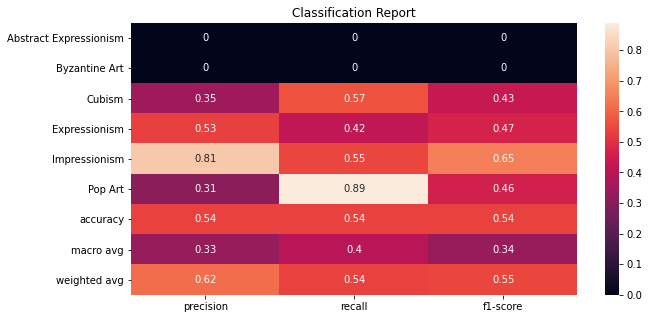

precision    recall  f1-score    support
Abstract Expressionism   0.000000  0.000000  0.000000    2.00000
Byzantine Art            0.000000  0.000000  0.000000   10.00000
Cubism                   0.352113  0.568182  0.434783   44.00000
Expressionism            0.533333  0.421053  0.470588   19.00000
Impressionism            0.806452  0.547445  0.652174  137.00000
Pop Art                  0.313725  0.888889  0.463768   18.00000
accuracy                 0.539130  0.539130  0.539130    0.53913
macro avg                0.334271  0.404261  0.336885  230.00000
weighted avg             0.616336  0.539130  0.546814  230.00000

In [68]:
test_generator.reset()
r50wpred = r50wmodel.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'resnet50_model_weighted_results')
metric_eval(test_generator, r50wpred, results, labels=os.listdir(train))

# TRANSFER LEARNING RESNET50 with ImageNet

In [6]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size+(3,))

x = base_model.output
x = Flatten()(base_model.output) #last_output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)                  

x = Dense (num_classes, activation='softmax')(x)           

transfer_model = Model(inputs=base_model.input, outputs=x)

In [8]:
transfer_model.load_weights('../models/r50_transfer_checkpoint_25.h5')

We will continue to use the ADAM optimizer with a lower learning rate

In [17]:
transfer_model.compile(optimizer=Adam(lr=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'r50_transfer_checkpoint_{epochs}.h5')),]

history = transfer_model.fit(train_generator, 
                    epochs=epochs,
                    callbacks=callbacks, 
                    validation_data=validation_generator,
                    batch_size=batch_size)

Epoch 1/25
43/43 [==============================] - 612s 14s/step - loss: 1.9920 - accuracy: 0.4944 - val_loss: 3.6130 - val_accuracy: 0.0777
Epoch 2/25
43/43 [==============================] - 583s 14s/step - loss: 0.9110 - accuracy: 0.7010 - val_loss: 7.5556 - val_accuracy: 0.0777
Epoch 3/25
43/43 [==============================] - 589s 14s/step - loss: 0.6521 - accuracy: 0.7809 - val_loss: 13.7616 - val_accuracy: 0.0777
Epoch 4/25
43/43 [==============================] - 660s 15s/step - loss: 0.4810 - accuracy: 0.8394 - val_loss: 12.3204 - val_accuracy: 0.0777
Epoch 5/25
43/43 [==============================] - 695s 16s/step - loss: 0.3534 - accuracy: 0.8779 - val_loss: 15.2492 - val_accuracy: 0.0777
Epoch 6/25
43/43 [==============================] - 646s 15s/step - loss: 0.2988 - accuracy: 0.8912 - val_loss: 13.3256 - val_accuracy: 0.0777
Epoch 7/25
43/43 [==============================] - 659s 15s/step - loss: 0.2308 - accuracy: 0.9127 - val_loss: 13.6401 - val_accuracy: 0.0777
E

In [18]:
#Save train/val accuracy and train/val loss
r50_transfer_hist = pd.DataFrame(history.history)
r50_transfer_hist.to_csv(f'../results/r50_transfer_hist_{epochs}epochs.csv', index=False)

In [9]:
test_generator.reset()
r50tpred = transfer_model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, r50tpred, 'r50transfer_model_results')

230/230 [==============================] - 22s 94ms/step


C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

precision    recall  f1-score     support
Abstract Expressionism   0.000000  0.000000  0.000000    2.000000
Byzantine Art            0.470588  0.800000  0.592593   10.000000
Cubism                   0.775510  0.863636  0.817204   44.000000
Expressionism            0.833333  0.526316  0.645161   19.000000
Impressionism            0.940299  0.919708  0.929889  137.000000
Pop Art                  0.944444  0.944444  0.944444   18.000000
accuracy                 0.865217  0.865217  0.865217    0.865217
macro avg                0.660696  0.675684  0.654882  230.000000
weighted avg             0.871663  0.865217  0.863199  230.000000

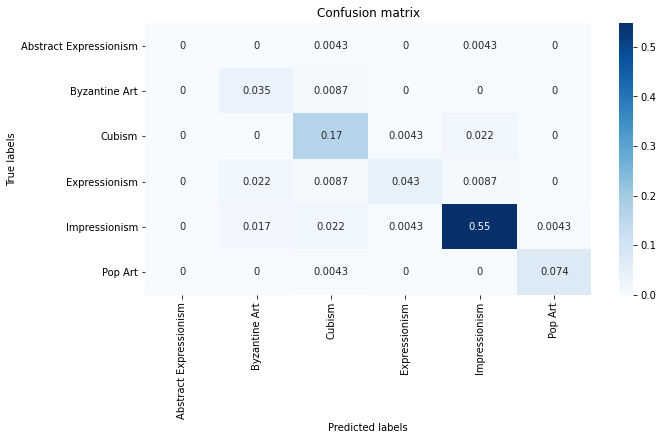

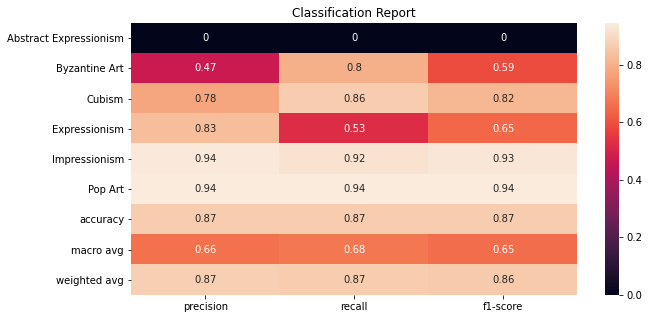

In [28]:
metric_eval(test_generator, r50tpred, results, labels=os.listdir(train))

# RESULTS

In [19]:
# LOAD ALL MODEL RESULTS BY EPOCH
cnn_df = pd.read_csv('../results/cnn_hist_25epochs.csv')
cnnw_df = pd.read_csv('../results/weight_cnn_hist_25epochs.csv')
r50_df = pd.read_csv('../results/r50_hist_25epochs.csv')
r50w_df = pd.read_csv('../results/r50_weight_hist_25epochs.csv')
r50t_df = pd.read_csv('../results/r50_transfer_hist_25epochs.csv')

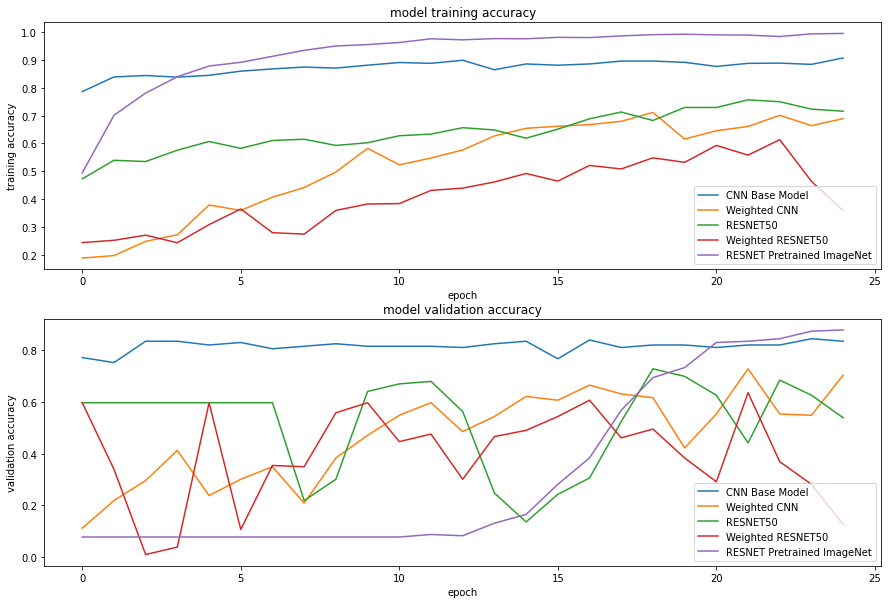

In [33]:
# PLOT AND COMPARE ACCURACY

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(cnn_df['accuracy'])
plt.plot(cnnw_df['accuracy'])
plt.plot(r50_df['accuracy'])
plt.plot(r50w_df['accuracy'])
plt.plot(r50t_df['accuracy'])
plt.title('model training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['CNN Base Model', 'Weighted CNN', 'RESNET50', 'Weighted RESNET50', 'RESNET Pretrained ImageNet'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(cnn_df['val_accuracy'])
plt.plot(cnnw_df['val_accuracy'])
plt.plot(r50_df['val_accuracy'])
plt.plot(r50w_df['val_accuracy'])
plt.plot(r50t_df['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['CNN Base Model', 'Weighted CNN', 'RESNET50', 'Weighted RESNET50', 'RESNET Pretrained ImageNet'], loc='lower right')

plt.savefig(f'../img_metrics/train_val_accuracy.jpg', bbox_inches='tight')

# BEST METRICS: PRE-TRAINED RESNET50

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

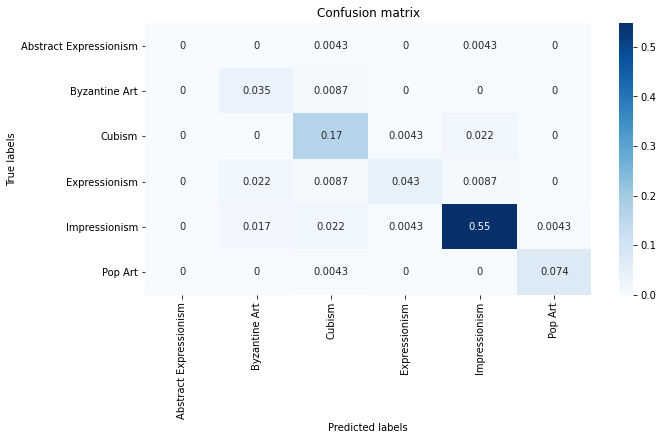

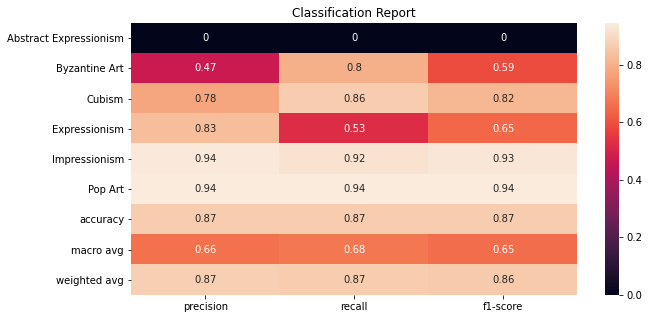

In [29]:
cm = confusion_matrix(list(results.True_Label), list(results.Predictions), labels=os.listdir(train))
plot_confusion_matrix(cm, os.listdir(train))
plt.savefig(f'../img_metrics/transfer_confusion_matrix.jpg', bbox_inches='tight')
cf = cf_report(test_generator, r50tpred, os.listdir(train))
plot_clf(cf)
plt.savefig(f'../img_metrics/transfer_classification_heatmap.jpg', bbox_inches='tight')

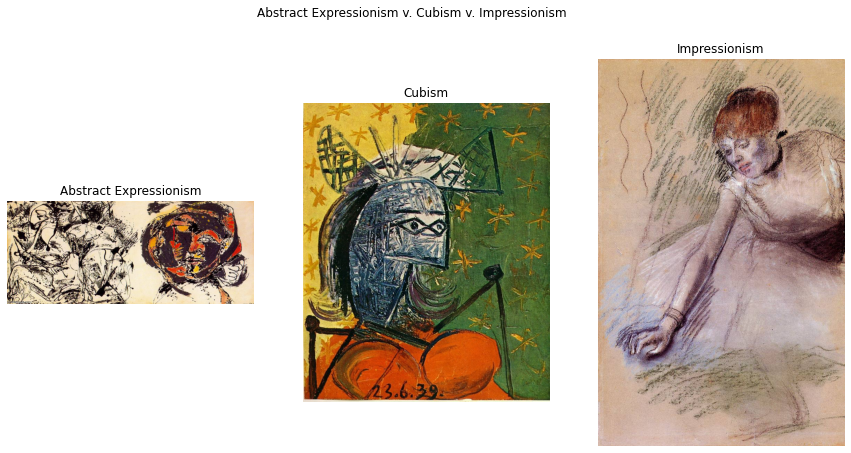

In [117]:
filepath = {'Abstract Expressionism':'../train_images/Abstract Expressionism/Jackson_Pollock_18.jpg',
           'Cubism':'../train_images/Cubism/Pablo_Picasso_435.jpg',
           'Impressionism':'../train_images/Impressionism/Edgar_Degas_106.jpg'}

plt.figure(figsize=(15,15))
i=0

for label, file in filepath.items():
    ax = plt.subplot(1, 3, i + 1)
    image = plt.imread(file)
    plt.title(label)
    plt.imshow(image)
    plt.suptitle('Abstract Expressionism v. Cubism v. Impressionism', y=0.73)
    plt.axis('off')
    i+=1
plt.savefig(f'../graphs/comparison1.jpg', bbox_inches='tight')
plt.show()

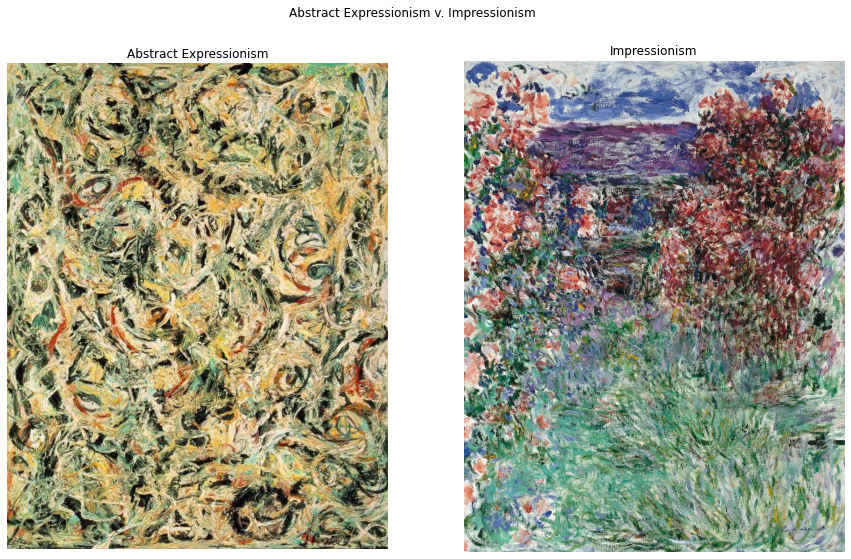

In [122]:
filepath = {'Abstract Expressionism':'../train_images/Abstract Expressionism/Jackson_Pollock_5.jpg',
            'Impressionism' :'../train_images/Impressionism/Claude_Monet_21.jpg'}

plt.figure(figsize=(15,15))
i=0

for label, file in filepath.items():
    ax = plt.subplot(1, 2, i + 1)
    image = plt.imread(file)
    plt.title(label)
    plt.imshow(image)
    plt.suptitle('Abstract Expressionism v. Impressionism', y=0.78)
    plt.axis('off')
    i+=1
plt.savefig(f'../graphs/comparison2.jpg', bbox_inches='tight')
plt.show()

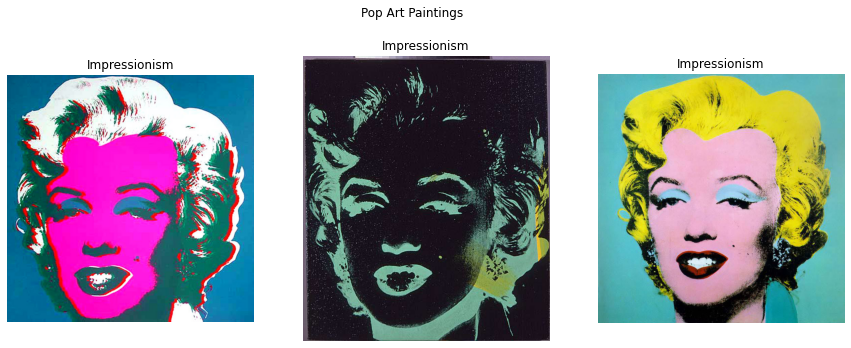

In [132]:
filepath = ['../train_images/Pop Art/Andy_Warhol_64.jpg',
'../train_images/Pop Art/Andy_Warhol_65.jpg',
'../train_images/Pop Art/Andy_Warhol_66.jpg']

plt.figure(figsize=(15,15))

for i in range(len(filepath)):
    ax = plt.subplot(1, 3, i + 1)
    image = plt.imread(filepath[i])
    plt.title(label)
    plt.imshow(image)
    plt.suptitle('Pop Art Paintings', y=0.68)
    plt.axis('off')
plt.savefig(f'../graphs/comparison3.jpg', bbox_inches='tight')
plt.show()